# **Proyecto para HACKATON BARCELONA DIGITAL TALENT**

# **APARTADO EDA**

## **Realizado por:** Esteban Braganza

En este cuaderno se desarrolla la parte de análisis exploratorio de las bases de datos propuestas para el concurso.

In [1]:

## Importamos librerías

import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

import numpy as np
import pandas as pd
import pickle
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
#from pandas_profiling.utils.cache import cache_file

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Librerias de modelado
from sklearn import model_selection as ms
from sklearn import preprocessing,linear_model## 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz




Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
### Algunas Funciones utiles

def set_others(df, column, num_values):
    """
    Esta funcion ayuda cuando tenemos variables categoricas con muchas categorias pero en donde los datos
    se distribuyen mayoritariamente en unas cuantas, de esta forma se pueden agrupar en una categoria others aquellas que tienen pocos casos.
    """
    top_categories = df[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    return pd.Categorical(df[column], categories=top_categories_list).fillna('Others')

def plot_categories(df, column, target,target_categoric=True):
    
    """Dibuja el numero de casos que tiene una categoria y tambien un boxplot con el target en caso de que el
    target es numerico. Si el target es categorico dibuja un grafico en el que vemos 
    cuanto discriminan las categorias"""
    if target_categoric== False:

      # Plot1
        
        plt.figure(figsize=(30,10))
        plt.subplot(2,1,1)
        splot=sns.countplot(df[column])

        for p in splot.patches:
          splot.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        size=15,
                        xytext = (0, -12), 
                        textcoords = 'offset points')
        
        #Plot 2
        
        plt.subplot(2,1,2)
        splot2=sns.boxenplot(
        data = df, 
        x = column,
        y = target)
        for p in splot2.patches:
          splot2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
        plt.xticks(rotation=45)

        # Show
        plt.show()


    else:
      
        plt.figure(figsize=(30,10))

        # Plot 1
        
        plt.subplot(2,1,1)
        splot=sns.countplot(df[column])
        for p in splot.patches:
          splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
          
        plt.xticks(rotation=45)

        # Plot 2

        plt.subplot(2,1,2)
        splot2=sns.countplot(x=column,hue=target, 
                    data=df)
        for p in splot2.patches:
          splot2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

        # Show      
        plt.show()
        
def obtener_lista_variables(dataset,target):
    
    '''Nos ayuda a separar entre variables categoricas booleanas y numericas'''
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset:
        if    (dataset[i].dtype=="float64" or dataset[i].dtype=="int64") and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (dataset[i].dtype=="float64" or dataset[i].dtype=="int64" or dataset[i].dtype=="int8" or dataset[i].dtype=="int32") and len(dataset[i].unique())== 2  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype=="object" or dataset[i].dtype.name == 'category')  and i not in target:
              lista_categoricas.append(i)
                
    return lista_numericas, lista_boolean, lista_categoricas

def OneHotEncoderFunction(df, column_name):
    _dummy_dataset = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, _dummy_dataset], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    return df

def generate_simple_report(data_frame):
  
  print('-- Un vistazo Rapido --')
  print(data_frame.head(10))
  print()
  print('-- Informacion de las Variables --')
  print(data_frame.info())
  print()
  print('-- Descripcion de las Variables --')
  print(data_frame.describe())
  print()
  print('--Nulos dentro del Data Set --')
  print(pd.DataFrame(data_frame.isnull().sum(), columns =['NULOS']).reset_index().sort_values(by ='NULOS', ascending = True))
  print()
  print('--Valores Duplicados--')
  print('Duplicados: ',data_frame.duplicated().sum())
  print()
  print('--Valores Unicos--')
  print(pd.DataFrame(data_frame.nunique(),columns=['unique_values']).reset_index().sort_values('unique_values',ascending=False))



## **Importación de datos**

In [3]:
clients = pd.read_csv('/content/drive/MyDrive/Hackaton Barcelona/mwc22-client_table.csv')
orders = pd.read_csv('/content/drive/MyDrive/Hackaton Barcelona/mwc22-orders_table.csv')

## **Contenido de la parte EDA**

1) Generalidades de cada Data Set, variables, número de registros y análisis de nulos y duplicados.

2) Análisis del data set de clientes, cuántos clientes únicos son, diferencias entre segmentos cuantos recibieron la notificación.

3) Análisis simple de las variables numéricas, distribuciones y outliers, correcciones y resultados de los data sets.

4) Análisis del consumo medio y del tamaño de la canasta medio por tipo de cliente e impacto de la comunicación.

5) Cómo se ven los datos después de una estadarización o de transformarlos a logaritmos utilizamos un scatter plot.

6) Análisis del data set de órdenes, número de órdenes por segmento, e impacto de la comunicación.

7) Cuáles son los productos más consumidos. Análisis de productos e impacto de la comunicación en su consumo total. Top 5 productos por segmento de cliente.

8) Conclusiones generales


## Generalidades de los Data Sets

- **Clients:** El data set de Clients tiene 35884 registros los cuales representan cada uno a un único id de cliente. Además se divide en 6 segmentos de clientes distintos. Las variables consumo promedio y tamaño medio de la canasta se encuentran como variables categóricas cuando se esperaría que sean numéricas. Este data set no presenta nulos ni duplicados.

- **Acciones a realizar:** Modificar el tipo de datos de las variables numéricas.

In [4]:
generate_simple_report(clients)

-- Un vistazo Rapido --
   CLIENT ID  CLIENT_SEGMENT AVG CONSO AVG BASKET SIZE  RECEIVED_COMMUNICATION
0   24321771               6     67,25          201,75                       0
1   24321859               2     58,33             350                       0
2   24321880               3     46,67             112                       0
3   24321957               2        50             600                       0
4   24321962               4        10             120                       0
5   24322000               5      9,17             110                       0
6   24322006               3     58,33             100                       0
7   24322026               4     29,17            87,5                       0
8   24322170               1    116,67             200                       0
9   24322371               2     83,33             200                       0

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 3

In [5]:
# Reemplazamos comas por puntos en variables que deben ser numericas y estan como categoricas, despues las transformamos en floats

clients['AVG BASKET SIZE'] = clients['AVG BASKET SIZE'].str.replace(',','.')
clients['AVG CONSO'] = clients['AVG CONSO'].str.replace(',','.')
clients['AVG BASKET SIZE'] = clients['AVG BASKET SIZE'].apply(lambda x: float(x))
clients['AVG CONSO'] = clients['AVG CONSO'].apply(lambda x: float(x))



- **Orders:** El data set de órdenes cuenta con 66912 registros de los cuales tenemos 17458 clientes que han realizado una órden y 14499 órdenes distintas. Tenemos 24 tipos de fruta que se ofrecen en la tienda. El data set no presenta nulos y presenta 616 duplicados que se deben analizar pues es muy probable que los clientes hagan pedidos similares en más de una ocasión. En esta base de datos no tenemos información de la segmentación de clientes ni de si recibieron o no la comunicación.

- **Acciones:** Considerar a los duplicados que hemos encontrado. 

In [6]:
generate_simple_report(orders)

-- Un vistazo Rapido --
   CLIENT ID  NB PRODS   ORDER ID FRUIT_PRODUCT
0   18070505         5  671907264         Apple
1   18070505        10  671907264        Orange
2   18070505         5  671907264          Kiwi
3   18070505        10  671907264          Pear
4   18070505         5  671907264        Cheery
5   18071016         5  675229714    Watermelon
6   18071016        10  675229714        Orange
7   18071016        10  675229714    Strawberry
8   18071016         5  675229714     Nectarine
9   18071016        15  675229714        Cheery

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66912 entries, 0 to 66911
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CLIENT ID      66912 non-null  int64 
 1   NB PRODS       66912 non-null  int64 
 2   ORDER ID       66912 non-null  int64 
 3   FRUIT_PRODUCT  66912 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.0+

In [7]:
generate_simple_report(orders[orders.duplicated()])

-- Un vistazo Rapido --
      CLIENT ID  NB PRODS   ORDER ID FRUIT_PRODUCT
44     18073169         3  675518868          Kiwi
145    18085027         2  667270285        Orange
296    18102594         1  675879875        Orange
444    18122931         5  672907483          Kiwi
561    18138968         2  675881310        Orange
633    18148878         8  667271287        Orange
887    18187479         8  668683829         Lemon
1090   18219973         2  672188691         Lemon
1113   18222950         1  668386797       Coconut
1145   18225093         2  667749271        Orange

-- Informacion de las Variables --
<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 44 to 66835
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CLIENT ID      616 non-null    int64 
 1   NB PRODS       616 non-null    int64 
 2   ORDER ID       616 non-null    int64 
 3   FRUIT_PRODUCT  616 non-null    object
dtypes: int64(

# **Clients Data Set**

### **Número de clientes**

- A continuacion podemos observar el número de clientes por segmento, los segmentos más numerosos son el 3 y 4 con alrededor de 8000 registros cada uno. Le sguien los segmentos 1 y 2 con alrededor de 6500 clientes. Finalmente los segmentos menos numerosos son los 5 y 6 en un rango entre 3000 y 3500 clientes.

- Además se puede observar que en general cada segmento tiene un número balanceado entre los clientes que recibieron la comunicacion y los que no. Sólo en el segmento 5 predominan los clientes que no recibieron la comunicación con 2577 casos frente a 852 que sí reciben.

- En el total de la base de datos tenemos que aproximadamente la mitad de los clientes recibieron la comunicacion y la mitad no.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


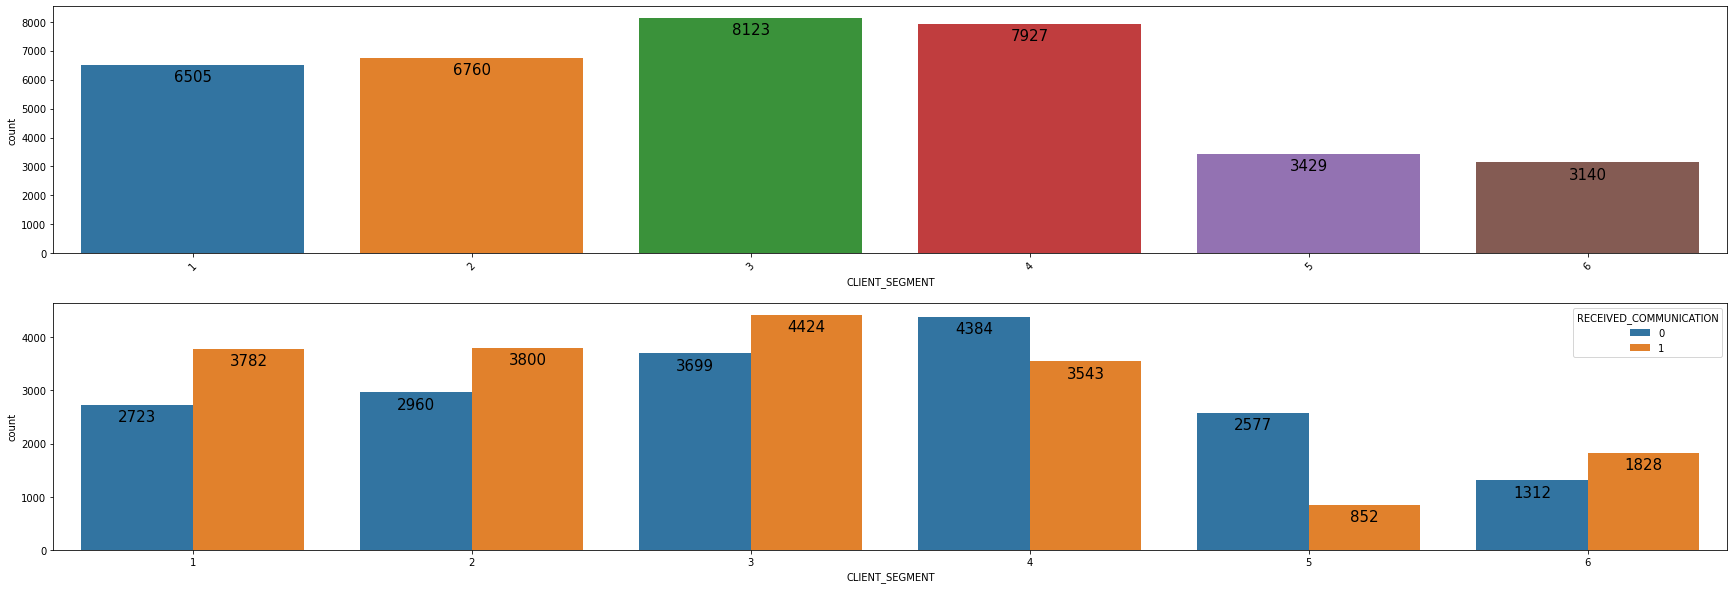

In [8]:
# Número de Clientes por Segmento y que han recibido o no la Comunicación.

plot_categories(clients, column ='CLIENT_SEGMENT', target ='RECEIVED_COMMUNICATION', target_categoric=True )

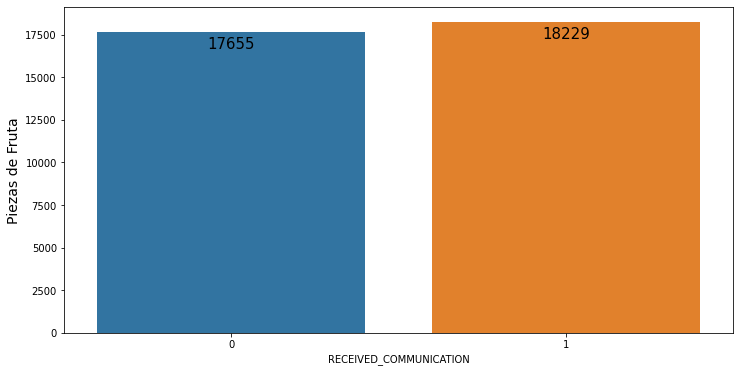

In [9]:
plt.figure(figsize=(12,6))

p3 = sns.countplot(data=clients, x = 'RECEIVED_COMMUNICATION')

for p in p3.patches:
          p3.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Piezas de Fruta", size = 14)
          
plt.show()

## **Análisis de Variables Númericas**

### **Distribuciones y Outliers**

In [10]:
# Para el analisis calcularemos el logaritmo natural de las variables numericas, realizaremos una estandarizacion robusta y observamos como se comporta cada opcion

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

clients['LOG_AVG_CONSO'] = np.log(clients['AVG CONSO'])
clients['LOG_AVG_BASKET_SIZE'] = np.log(clients['AVG BASKET SIZE'])
clients['SCALED_AVG_CONSO'] = qt.fit_transform(clients[['AVG CONSO']].values.reshape(-1,1))
clients['SCALED_AVG_BASKET_SIZE'] = qt.fit_transform(clients[['AVG BASKET SIZE']].values.reshape(-1,1))

# Transformo en categorica a la variable segment
clients['CLIENT_SEGMENT'] = clients['CLIENT_SEGMENT'].astype('string')

clients_without_outliers = clients[(clients['AVG CONSO'] < 300) & (clients['AVG BASKET SIZE'] < 1500)]
clients_without_outliers['CLIENT_SEGMENT'] = clients_without_outliers['CLIENT_SEGMENT'].astype('string')



- Podemos observar la distribución de las variables numéricas, en general podemos observar que tienen distribuciones sesgadas a la derecha con una larga cola. Esto nos muestra la presencia de outliers que son mucho mayores que la media.

- Este efecto puede observarse en las distribuciones de ambas variables. 

- Para lidiar con este problema de no normalidad y outliers probaremos 3 métodos diferentes y compararemos sus distribuciones, box plots y scatterplots. 

- Nuestras opciones son eliminar los valores extremos, obtener el logaritmo natural de las variables o realizar un escalado de cuantiles.

- Vemos que no es necesario eliminar observaciones extremas pues tanto el obtener logaritmos como la estandarización obtienen resultados excelentes en cuanto la normalización de las variables. Siendo el la normalización muy superior ya que la variable llega a acercarse mucho más a la normalidad.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

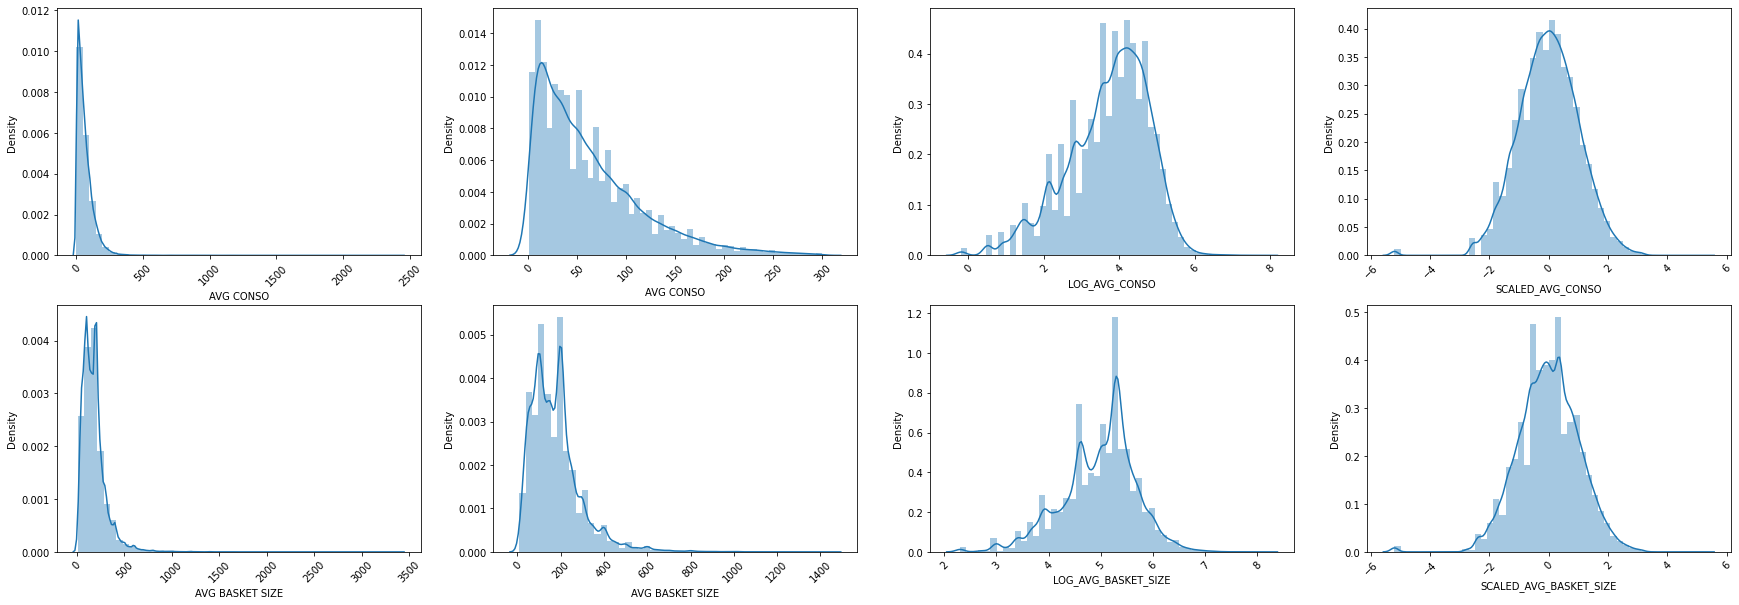

In [11]:
# Average Consumption Distribution

plt.figure(figsize=(30,10))

# Dist sin modificacion
plt.subplot(2,4,1)
sns.distplot(clients['AVG CONSO'], bins=50)
plt.xticks(rotation=45)

#Dist sin outliers
plt.subplot(2,4,2)
sns.distplot(clients_without_outliers['AVG CONSO'],bins=50)
plt.xticks(rotation=45)

#Dist log de variable
plt.subplot(2,4,3)
sns.distplot(clients['LOG_AVG_CONSO'],bins=50)
plt.xticks(rotation=45)

#Dist quantile scaled variable
plt.subplot(2,4,4)
sns.distplot(clients['SCALED_AVG_CONSO'],bins=50)
plt.xticks(rotation=45)


# Dist sin modificacion
plt.subplot(2,4,5)
sns.distplot(clients['AVG BASKET SIZE'], bins=50)
plt.xticks(rotation=45)

#Dist sin outliers
plt.subplot(2,4,6)
sns.distplot(clients_without_outliers['AVG BASKET SIZE'],bins=50)
plt.xticks(rotation=45)

#Dist log de variable
plt.subplot(2,4,7)
sns.distplot(clients['LOG_AVG_BASKET_SIZE'],bins=50)
plt.xticks(rotation=45)

#Dist quantile scaled variable
plt.subplot(2,4,8)
sns.distplot(clients['SCALED_AVG_BASKET_SIZE'],bins=50)
plt.xticks(rotation=45)

plt.show()

### **Scatter plot y separibildad de los datos**

- En cuanto a la separabilidad de los datos (que nos servirá después cuando realizemos la clasificación) vemos que al estandarizar los datos obtenemos el mejor resultado ya que podemos observar claramente los grupos y su delimitación es mucho más sencilla visualmente. Esto también se da con los logaritmos pero una vez más la estandarización parece la mejor opción.

- Aunque los grupos se pueden delimitar facilmente de manera visual estos no parecen ser linealmente separables aunque en el caso del logartimo podria darse el caso.

In [12]:
fig = px.scatter(clients, x= 'AVG CONSO', y= 'AVG BASKET SIZE', color='CLIENT_SEGMENT', color_discrete_sequence=px.colors.qualitative.T10, title = 'Scatter plot datos sin procesar')

fig.show()

In [13]:
fig = px.scatter(clients, x= 'SCALED_AVG_CONSO', y= 'SCALED_AVG_BASKET_SIZE', color='CLIENT_SEGMENT', color_discrete_sequence=px.colors.qualitative.T10, title = 'Scatter plot datos estandarizados')
fig.show()

In [14]:
fig = px.scatter(clients, x= 'LOG_AVG_CONSO', y= 'LOG_AVG_BASKET_SIZE', color='CLIENT_SEGMENT', color_discrete_sequence=px.colors.qualitative.T10, title = 'Scatter plot datos en logaritmo natural')
fig.show()

### **Box Plots**

- En el caso de los box plots también se puede observar que el problema de los outliers se soluciona con la transformación de datos, lo cual es positivo pues podremos mantener la información de aquellos clientes que tienen consumos y tamaños de canasta promedios más altos.

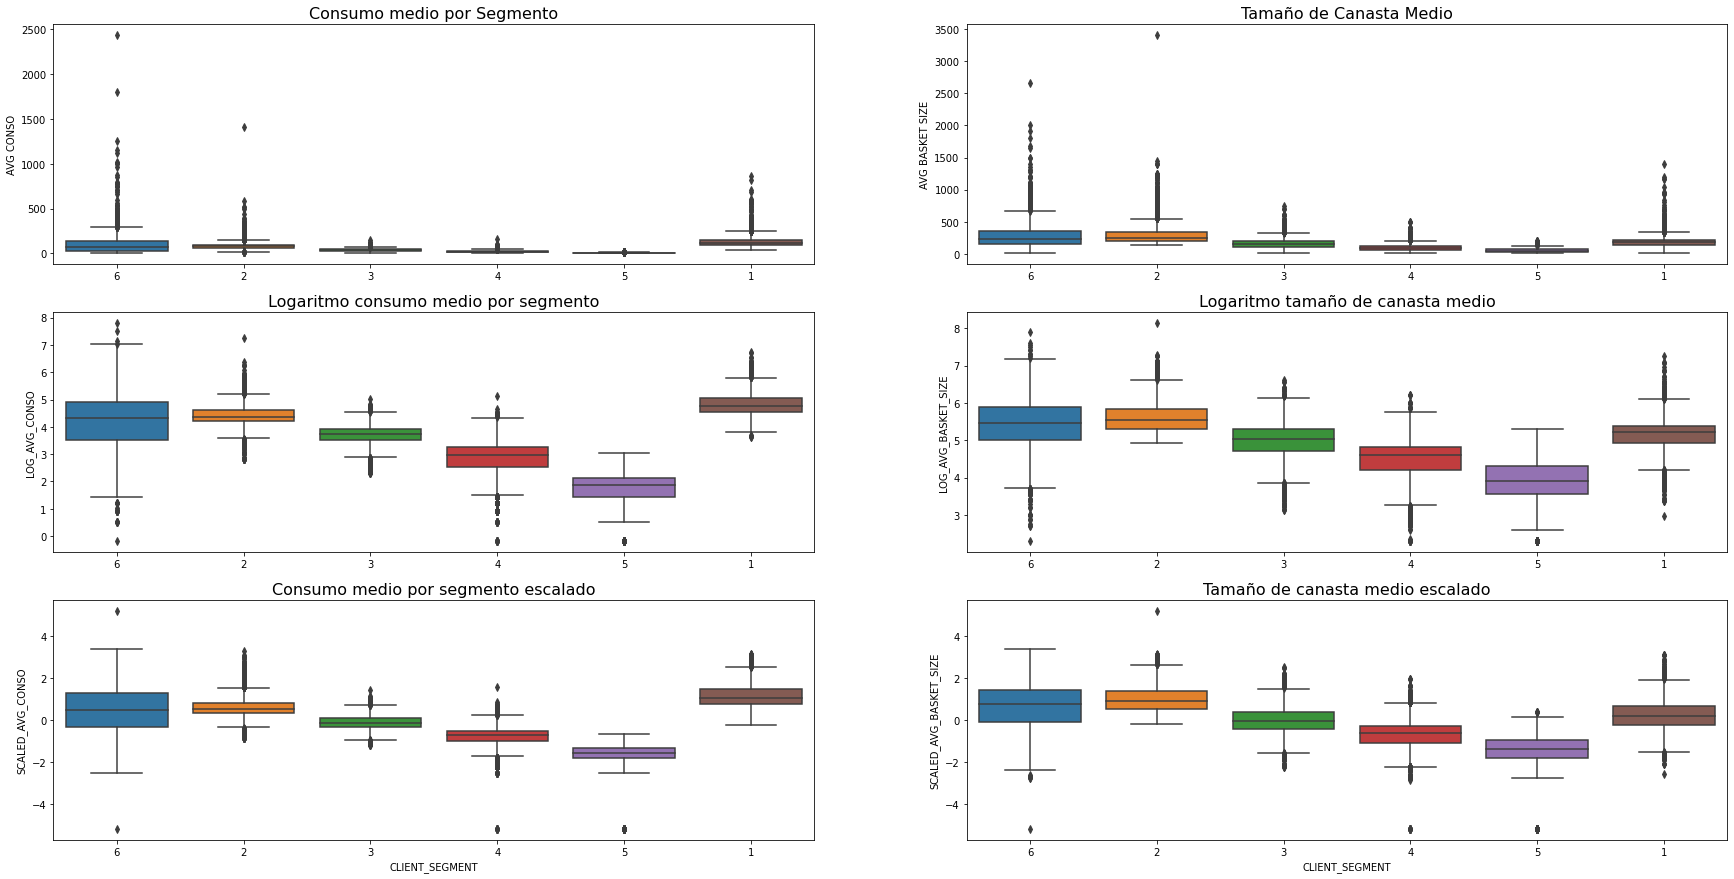

In [15]:
# Box Plots

plt.figure(figsize=(30,15))

plt.subplot(3,2,1)

ax=sns.boxplot(data=clients, x= 'CLIENT_SEGMENT', y = 'AVG CONSO')
plt.title('Consumo medio por Segmento', size=16)
ax.set(xlabel=None)

plt.subplot(3,2,2)

ax2=sns.boxplot(data=clients, x= 'CLIENT_SEGMENT', y = 'AVG BASKET SIZE')
plt.title('Tamaño de Canasta Medio', size=16)
ax2.set(xlabel=None)

plt.subplot(3,2,3)

ax3 = sns.boxplot(data=clients, x= 'CLIENT_SEGMENT', y = 'LOG_AVG_CONSO')
plt.title('Logaritmo consumo medio por segmento', size=16)
ax3.set(xlabel=None)

plt.subplot(3,2,4)

ax4 = sns.boxplot(data=clients, x= 'CLIENT_SEGMENT', y = 'LOG_AVG_BASKET_SIZE')
plt.title('Logaritmo tamaño de canasta medio', size=16)
ax4.set(xlabel=None)

plt.subplot(3,2,5)

ax3 = sns.boxplot(data=clients, x= 'CLIENT_SEGMENT', y = 'SCALED_AVG_CONSO')
plt.title('Consumo medio por segmento escalado', size=16)


plt.subplot(3,2,6)

ax4 = sns.boxplot(data=clients, x= 'CLIENT_SEGMENT', y = 'SCALED_AVG_BASKET_SIZE')
plt.title('Tamaño de canasta medio escalado', size=16)


plt.show()

## **Análisis del consumo y canasta media de los clientes**




In [16]:
mean_consumption = clients_without_outliers.groupby(['CLIENT_SEGMENT','RECEIVED_COMMUNICATION'])['AVG CONSO'].agg(['mean','median']).reset_index()
basket_size = clients_without_outliers.groupby(['CLIENT_SEGMENT','RECEIVED_COMMUNICATION'])['AVG BASKET SIZE'].agg(['mean','median']).reset_index()

### **Consumo medio e impacto de comunicación**

- En cuanto al consumo medio podemos observar que si lo discriminamos por segmento son los segmentos 1, 6 y 2 los que mantienen un promedio mayor siendo el mayor el segmento 1. Estos resultados se dan aún quitando los outliers que sesgan hacia arriba las medias pero sin ellos mantenemos la tendencia. Por otro lado el segmento 5 es el que menor consumo tiene con un promedio de 7 piezas de fruta.

- Vemos que el efecto de la comunicación en el consumo medio es mayor a nivel segmento. Se puede observar que las diferencias entre aquellos que reciben la comunicación y los que no son más pronunciadas a nivel segmento que cuando lo comparamos sin diferenciar.

- El efecto es especialmente mayor en el segmento 6 con una diferencia de almenos 20 piezas en promedio. 

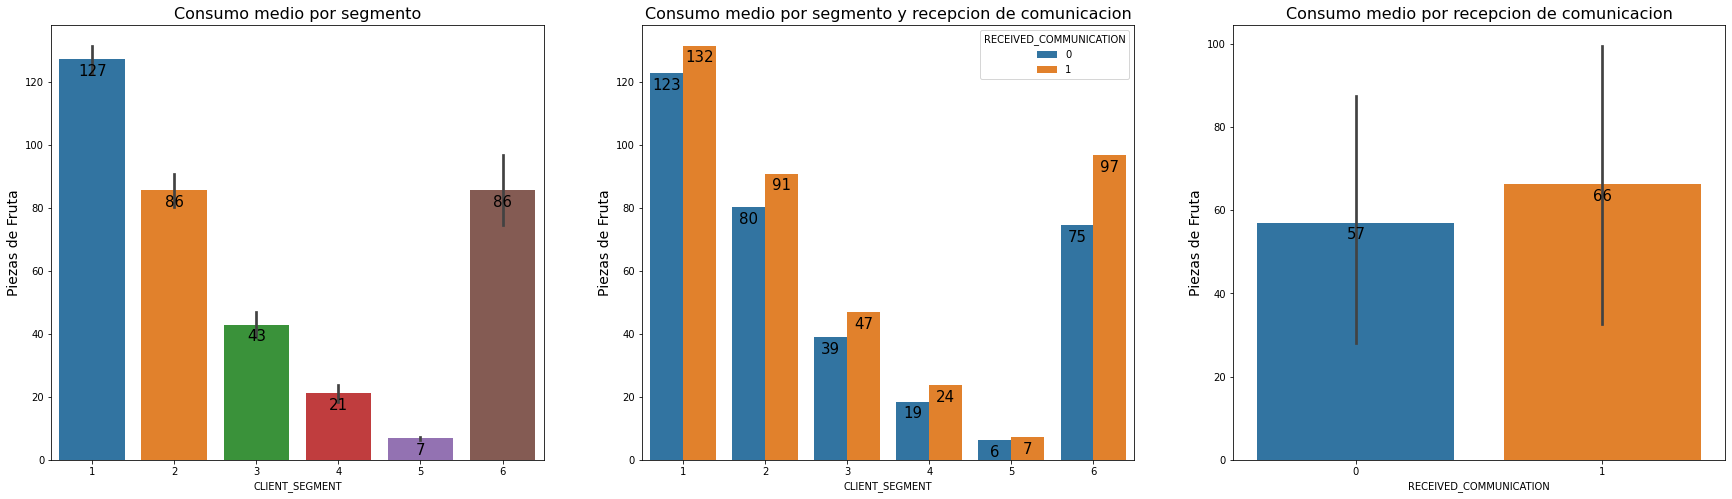

In [17]:
# Consumo Medio de los Clientes

plt.figure(figsize=(30,8))

# Plot 1 Consumo medio por Segmento

plt.subplot(1,3,1)
p1 = sns.barplot(data=mean_consumption, x= 'CLIENT_SEGMENT', y = 'mean')
for p in p1.patches:
          p1.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
          
plt.ylabel("Piezas de Fruta", size = 14)
plt.title('Consumo medio por segmento',size = 16)

# Consumo Medio por segmento y diferenciando si recibe o no la comunicación
plt.subplot(1,3,2)
p2 = sns.barplot(data=mean_consumption, x= 'CLIENT_SEGMENT', y = 'mean', hue = 'RECEIVED_COMMUNICATION')
for p in p2.patches:
          p2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Piezas de Fruta", size = 14)
plt.title('Consumo medio por segmento y recepcion de comunicacion',size = 16)
          

# Plot 3 Consumo medio entre los que recibieron o no la comunicación 

plt.subplot(1,3,3)
p3 = sns.barplot(data=mean_consumption, y = 'mean', x = 'RECEIVED_COMMUNICATION')

for p in p3.patches:
          p3.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Piezas de Fruta", size = 14)
plt.title('Consumo medio por recepcion de comunicacion',size = 16)
          
plt.show()

### **Tamaño medio de la canasta e impacto de la comunicación**

- En cuanto al tamaño medio de la canasta podemos observar que en promedio los segmentos 2 y 6 son los que compran canastas más grandes, mientras que el segmento compra las canastas más pequeñas.

- Vemos que el efecto de la comunicación en el tamaño medio de la canasta es mayor a nivel segmento. Se puede observar que las diferencias entre aquellos que reciben la comunicación y los que no, son más pronunciadas a nivel segmento que cuando lo comparamos sin diferenciar.

- El efecto es especialmente mayor en los segmentos 2 y 6, sin embargo el para los demás segmentos se puede observar que no tiene un efecto siginifcativo.

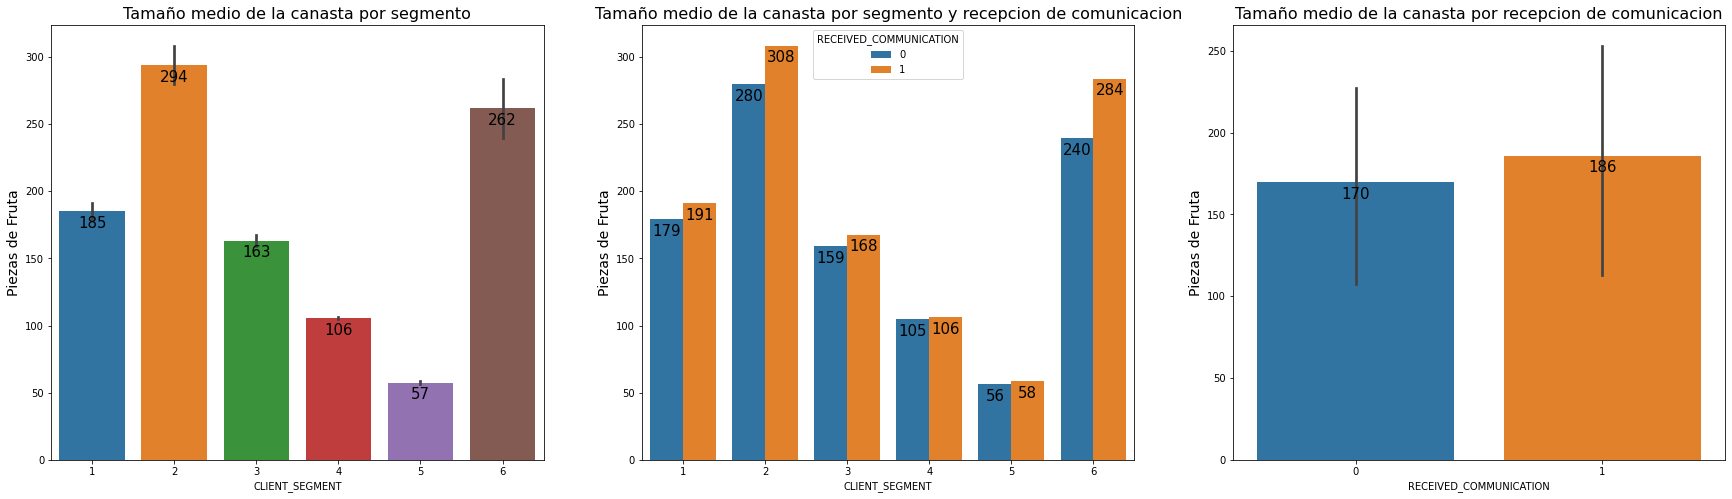

In [18]:
# Tamano de la canasta medio

plt.figure(figsize=(30,8))


# Plot 1 Tamaño medio de canasta por segmento

plt.subplot(1,3,1)

p1 = sns.barplot(data=basket_size, x= 'CLIENT_SEGMENT', y = 'mean')

for p in p1.patches:
  p1.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
  
plt.ylabel("Piezas de Fruta", size = 14)
plt.title('Tamaño medio de la canasta por segmento', size = 16)

# Plot 2 Tamaño medio de canasta por segmento diferenciado entre los que reciben la comunicación

plt.subplot(1,3,2)

p2 = sns.barplot(data=basket_size, x= 'CLIENT_SEGMENT', y = 'mean', hue = 'RECEIVED_COMMUNICATION')
for p in p2.patches:
  p2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Piezas de Fruta", size = 14)
plt.title('Tamaño medio de la canasta por segmento y recepcion de comunicacion',size = 16)


# Plot 3 Tamaño medio de canasta diferenciado entre los que reciben la comunicación

plt.subplot(1,3,3)
p3 = sns.barplot(data=basket_size, x= 'RECEIVED_COMMUNICATION', y = 'mean')
for p in p3.patches:
  p3.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel("Piezas de Fruta", size = 14)
plt.title('Tamaño medio de la canasta por recepcion de comunicacion',size = 16)


plt.show()

## **Análisis del data set de órdenes e impacto de la comunicación**

In [19]:
# Merge to obtain segments and  if they recevied communication

orders = orders.merge(clients[['CLIENT ID', 'CLIENT_SEGMENT','RECEIVED_COMMUNICATION']],"left", on ="CLIENT ID" )
orders['CLIENT_SEGMENT'] = np.where(orders['CLIENT_SEGMENT'].isnull()== True,1,orders['CLIENT_SEGMENT'])
orders['RECEIVED_COMMUNICATION'] = np.where(orders['RECEIVED_COMMUNICATION'].isnull()== True,0,orders['RECEIVED_COMMUNICATION'])


### **Número de órdenes**

In [20]:
# Number of Orders

# Total Number of Orders
tot_orders = orders.groupby(['CLIENT_SEGMENT','RECEIVED_COMMUNICATION'])['ORDER ID'].agg(pd.Series.nunique).reset_index()
tot_orders['CLIENT_SEGMENT'] = tot_orders['CLIENT_SEGMENT'].map(lambda x: 'Segment '+ str(int(x)))
tot_orders['RECEIVED_COMMUNICATION'] = np.where(tot_orders['RECEIVED_COMMUNICATION'] == 1, 'YES', 'NO')

# For Total Orders without communication variable
tot_orders_ = tot_orders[['CLIENT_SEGMENT','ORDER ID']].groupby('CLIENT_SEGMENT')['ORDER ID'].sum().reset_index()

- En este apartado se puede observar que los clientes del segmento 1 son los que realizan más órdenes, le siguen los clientes del segmento 3. Los clientes del segmento 5 son los que menos órdenes realizan, siendo consistente con lo que veíamos antes con el consumo y tamaño de canasta medios.

In [21]:
fig = px.bar(data_frame=tot_orders_.sort_values(by='ORDER ID', ascending=False), x = 'CLIENT_SEGMENT',  y= 'ORDER ID',color='CLIENT_SEGMENT', height=400, title= 'Número de órdenes por segmento')
fig.show()

- En cuanto al impacto de la comunicación en las órdenes de compra se puede observar que de manera significativa que los clientes que recibieron la comunicación han realizado un mayor número de órdenes de compra. Solo en el segmento 5 se ve una relación inversa, sin embargo sabemos que es el segmento de menor consumo y órdenes, por lo que se puede decir que son los menos comprometidos.

In [22]:
fig = px.bar(data_frame=tot_orders, x = 'CLIENT_SEGMENT',  y= 'ORDER ID', color= 'RECEIVED_COMMUNICATION', height=400,barmode="group", title= 'Número de órdenes por segmento e impacto de la comunicación')
fig.add_scatter(x = tot_orders_['CLIENT_SEGMENT'], y = tot_orders_['ORDER ID'], name = 'TOTAL ORDERS')
fig.show()

### **Volúmen de productos**

In [23]:
# Obtenemos dataframes con información de número de productos 1 producto = 10 piezas de fruta
tot_prods_segment = orders.groupby(['CLIENT_SEGMENT'])['NB PRODS'].agg(sum).reset_index()
tot_prods_segment_ = orders.groupby(['CLIENT_SEGMENT','RECEIVED_COMMUNICATION'])['NB PRODS'].agg(sum).reset_index()
tot_prods_segment_['RECEIVED_COMMUNICATION'] = tot_prods_segment_['RECEIVED_COMMUNICATION'].astype('str') 


- Podemos observar que el segmento 1 se mantiene como el más consumidor pues en volúmen de productos son los que más compran, seguidos por el segmento 2. Se puede observar que este último hace menos órdenes pero compran una mayor cantidad con menos órdenes.

In [24]:
fig = px.bar(data_frame=tot_prods_segment.sort_values(by='NB PRODS', ascending=False), x = 'CLIENT_SEGMENT',  y= 'NB PRODS',color='CLIENT_SEGMENT', height=400)
fig.show()


### **Efecto de la comunicación**

- Se puede observar que el número de productos que se compran también es muy sensible a la recepción de la comunicación existe una diferencia importante entre el volúmen de aquellos que la reciben y aquellos que no. En general, se puede observar que aquellos que recibieron la comunicación compran mucho más que aquellos que no.

In [25]:
fig = px.bar(data_frame=tot_prods_segment_.sort_values(by='NB PRODS', ascending=False), x = 'CLIENT_SEGMENT',  y= 'NB PRODS',color='RECEIVED_COMMUNICATION', height=400, barmode ='group')
fig.show()

### **Productos más consumidos y efecto de la comunicación**

- En este apartado podemos ver que las frutas más consumidas son el kiwi, el limón y la naranja mientras que el jackfruit y el melón son las menos populares. 

In [26]:
# Most consumed fruit product

fruit_tot = orders[['FRUIT_PRODUCT', 'NB PRODS']].groupby('FRUIT_PRODUCT').sum().sort_values(ascending = False, by= 'NB PRODS').reset_index()

fig = px.bar(data_frame=fruit_tot, x = 'FRUIT_PRODUCT',  y= 'NB PRODS', height=400,barmode="group")
fig.show()


- Se puede observar que además la cantidad de consumida es sensible al hecho de recibir o no a comunicacion pues en general podemos observar que los clientes que reciben la comunicación tienden a consumir una mayor cantidad de cada producto que aquellos que no reciben la comunicación.

In [27]:
# Most consumed fruit product

fruit_tot_received = orders[['FRUIT_PRODUCT', 'NB PRODS','RECEIVED_COMMUNICATION']].groupby(['FRUIT_PRODUCT','RECEIVED_COMMUNICATION']).sum().sort_values(ascending = False, by= 'NB PRODS').reset_index()
fruit_tot_received['RECEIVED_COMMUNICATION'] = fruit_tot_received['RECEIVED_COMMUNICATION'].astype('str')

fig = px.bar(data_frame=fruit_tot_received, x = 'FRUIT_PRODUCT',  y= 'NB PRODS', height=400,barmode="group", color = 'RECEIVED_COMMUNICATION')
fig.show()

In [28]:
# Top 5 Fruits consumed by segment
top_fruits = orders[['FRUIT_PRODUCT', 'NB PRODS','CLIENT_SEGMENT']].groupby(['CLIENT_SEGMENT','FRUIT_PRODUCT'])['NB PRODS'].sum().reset_index()
top_fruits['CLIENT_SEGMENT'] = top_fruits['CLIENT_SEGMENT'].map(lambda x: 'Segment '+ str(int(x)))
top_fruits = top_fruits.groupby('CLIENT_SEGMENT').apply(lambda x: x.nlargest(5,['NB PRODS'])).reset_index(drop=True)

- Finalmente podemos observar que en todos los segmentos predominan el consumo del kiwi, limón y naranja sin variar en ninguno de los segmentos, vemos que son las frutas de consumo favoritas para todos los clientes.

In [29]:
fig = px.bar(data_frame=top_fruits, x = 'CLIENT_SEGMENT',  y= 'NB PRODS', height=400,barmode="group", color = 'FRUIT_PRODUCT')
fig.show()

##  **Conclusiones del EDA**

- Tenemos un data set no balanceado aunque las clases 3 y 4 tienen más observaciones no tenemos ninguna clase con datos insuficientes para realizar la modelización al separar las bases de entrenamiento y prueba tendremos que mantener la relacion entre las distintas clases.

- Los segmentos de clientes se diferencian en cuanto a su consumo medio y al tamaño de la canasta media 

-  Aunque algunos segmentos tienen outliers los datos son visualmente separables al realizar un proceso de estandarización o de obtención de logaritmos de las variables numéricas.

- La comunicación tiene un efecto positivo en en el caso del consumo medio en todos los segmentos, mientras que en el caso del tamaño de la canasta media tiene un efecto positivo en los segmento 2 y 6 que son los que compran un tamano de canasta mas grande.

- Los segmentos 1 y 6 tienen el mayor consumo promedio mientras que el segmento 2 el mayor tamaño de canasta medio.

- El efecto positivo de haber recibido la comunicación también se ve reflejado en el número de órdenes que hace cada segmento de clientes y en el volumen de compra. Se puede observar que la comunicación afecta de forma significativa al número de órdenes y al volumen consumido siendo los clientes que recibieron la comunicacion mucho mas consumidores que aquellos que no.

- Los productos más consumidos son el kiwi, la naranja y el limón. Y se puede observar que la comunicación tabién influye de manera significativa en un mayor consumo en cada uno de estos productos. En general los clientes que recibieron la comunicación tienden a tener un volumen signficativamente mayor que los que no en todos los productos disponibles.